In [64]:
import pandas as pd
import numpy as np
import datetime
from sqlalchemy import create_engine

from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, association_rules
from mlxtend.frequent_patterns import fpgrowth
import seaborn as sns

/Users/oujunhao/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# Part A: Datawarehouse

## Q1: Data Cube

### Data pre-processing

In [25]:
#Load the dataset
df_DW = pd.read_csv('DW_dataset.csv')

In [26]:
#Check the dataset
df_DW

,Employee ID,Name,Date of Birth,Gender,Job Title,Salary,Date Joined,Date Left,Address
0,100,Smith,12-Jan-74,M,Director,100000,01-Aug-01,NaN,"12, Green Avenue, Howth, Co. Dublin"
1,125,Jones,06-Apr-89,F,Technician,30000,01-May-01,31-Aug-02,"43, School Road, Malahide, Co. Dublin"
2,167,Davis,19-Jan-82,F,Senior Technician,50000,01-Dec-02,NaN,"10, Main Street, Naas, Co. Kildare"
3,200,O'Bien,03-May-97,M,Technician,25000,01-May-02,30-Nov-02,"Apt 02, High Court, Condalkin. Co. Dublin"
4,205,Edward,16-Nov-95,M,Technician,33000,01-Jan-01,NaN,"33, Barake Street, Clane, Co. Kildare"
5,216,Evans,22-Mar-95,F,S' Technician,44000,01-Aug-01,31-Mar-02,"143, High Street, Niwbridge, Co. Kildare"
6,220,Moore,28-Jun-96,F,Jnr. Technician,22000,01-Jan-02,NaN,"Apt 01, Shreedon Court, Rathcoole, Co. Dublin"
7,301,Rogers,14-Nov-75,M,Deputy Director,60000,01-May-02,NaN,"Manor House, Naas Road, Inchico, Co. Dublin"
8,303,Phillip,14-Oct-76,F,HR Manager,70000,01-Jan-02,NaN,"44, Dublin Road, Finglas, Co. Dublin"
9,344,Shane,06-Jul-86,M,"D"" Director",50000,01-Jan-01,30-Apr-02,"65, Waterway, Killiney, Co. Dublin"


In [27]:
#Check the data types
df_DW.dtypes

Employee ID       int64
 Name            object
Date of Birth    object
 Gender          object
Job Title        object
 Salary           int64
Date Joined      object
Date Left        object
Address          object
dtype: object

In [28]:
#Convert the datatype properly
df_DW['Date of Birth'] = df_DW['Date of Birth'].astype('Datetime64')
df_DW['Date Joined'] = df_DW['Date Joined'].astype('Datetime64')
df_DW['Date Left'] = df_DW['Date Left'].astype('Datetime64')

In [29]:
# #Check the values in 'Job Title' and edit irregular values 
# df_DW.loc[df_DW['Job Title']=="S' Technician"] = 'Senior Technician'
# df_DW.loc[df_DW['Job Title']=='Jnr. Technician'] = 'Junior Technician'
# df_DW.loc[df_DW['Job Title']=="J Technician"] = 'Junior Technician'
# df_DW.loc[df_DW['Job Title']=='D" Director'] = 'Department Director'
# df_DW.loc[df_DW['Job Title']=="Dep. Director"] = 'Department Director'
# df_DW.loc[df_DW['Job Title']=="Eng` Manager"] = 'Engineering Manager'

In [65]:
#Check the unique values in 'gender'
df_DW['gender'].unique()

array([' M', ' F', 'F', 'M'], dtype=object)

In [68]:
#Replace the irregular space
df_DW['gender'] = df_DW['gender'].replace(" M","M")
df_DW['gender'] = df_DW['gender'].replace(" F","F")
df_DW['gender'].unique()

array(['M', 'F'], dtype=object)

In [69]:
#Change the column titles
df_DW.columns = ["employee_id","employee_name","date_of_birth","gender","job_title","salary","date_joined","date_left","address"]
df_DW

,employee_id,employee_name,date_of_birth,gender,job_title,salary,date_joined,date_left,address
0,100,Smith,1974-01-12,M,Director,100000,2001-08-01,NaT,"12, Green Avenue, Howth, Co. Dublin"
1,125,Jones,1989-04-06,F,Technician,30000,2001-05-01,2002-08-31,"43, School Road, Malahide, Co. Dublin"
2,167,Davis,1982-01-19,F,Senior Technician,50000,2002-12-01,NaT,"10, Main Street, Naas, Co. Kildare"
3,200,O'Bien,1997-05-03,M,Technician,25000,2002-05-01,2002-11-30,"Apt 02, High Court, Condalkin. Co. Dublin"
4,205,Edward,1995-11-16,M,Technician,33000,2001-01-01,NaT,"33, Barake Street, Clane, Co. Kildare"
5,216,Evans,1995-03-22,F,S' Technician,44000,2001-08-01,2002-03-31,"143, High Street, Niwbridge, Co. Kildare"
6,220,Moore,1996-06-28,F,Jnr. Technician,22000,2002-01-01,NaT,"Apt 01, Shreedon Court, Rathcoole, Co. Dublin"
7,301,Rogers,1975-11-14,M,Deputy Director,60000,2002-05-01,NaT,"Manor House, Naas Road, Inchico, Co. Dublin"
8,303,Phillip,1976-10-14,F,HR Manager,70000,2002-01-01,NaT,"44, Dublin Road, Finglas, Co. Dublin"
9,344,Shane,1986-07-06,M,"D"" Director",50000,2001-01-01,2002-04-30,"65, Waterway, Killiney, Co. Dublin"


In [35]:
#Set up the connection details
PORT = "localhost:5433"
DB = "practical2"
USER = "postgres"
PASSWARD = "ojh070897"

In [36]:
#Create a engine to connect to postgreSQL database
engine = create_engine("postgresql://{}:{}@{}/{}".format(USER, PASSWARD, PORT, DB))

In [37]:
connection = engine.engine

In [75]:
#We will save the df_DW as sql file
connection.execute("DROP TABLE IF EXISTS dw_clean;")
df_DW.to_sql('dw_clean',con=connection)

In [76]:
#make OLAP queries into a data frame
df_DW_new = pd.read_sql(sql="SELECT * FROM dw_clean;",con=connection)
df_DW_new

,index,employee_id,employee_name,date_of_birth,gender,job_title,salary,date_joined,date_left,address
0,0,100,Smith,1974-01-12,M,Director,100000,2001-08-01,NaT,"12, Green Avenue, Howth, Co. Dublin"
1,1,125,Jones,1989-04-06,F,Technician,30000,2001-05-01,2002-08-31,"43, School Road, Malahide, Co. Dublin"
2,2,167,Davis,1982-01-19,F,Senior Technician,50000,2002-12-01,NaT,"10, Main Street, Naas, Co. Kildare"
3,3,200,O'Bien,1997-05-03,M,Technician,25000,2002-05-01,2002-11-30,"Apt 02, High Court, Condalkin. Co. Dublin"
4,4,205,Edward,1995-11-16,M,Technician,33000,2001-01-01,NaT,"33, Barake Street, Clane, Co. Kildare"
5,5,216,Evans,1995-03-22,F,S' Technician,44000,2001-08-01,2002-03-31,"143, High Street, Niwbridge, Co. Kildare"
6,6,220,Moore,1996-06-28,F,Jnr. Technician,22000,2002-01-01,NaT,"Apt 01, Shreedon Court, Rathcoole, Co. Dublin"
7,7,301,Rogers,1975-11-14,M,Deputy Director,60000,2002-05-01,NaT,"Manor House, Naas Road, Inchico, Co. Dublin"
8,8,303,Phillip,1976-10-14,F,HR Manager,70000,2002-01-01,NaT,"44, Dublin Road, Finglas, Co. Dublin"
9,9,344,Shane,1986-07-06,M,"D"" Director",50000,2001-01-01,2002-04-30,"65, Waterway, Killiney, Co. Dublin"


1) Calculate the average salary of management staff for males and females separately. Consider all directors and managers in ‘Management’ and all technicians in the ‘Technical’ staff category.

In [77]:
#Calculate the avg salary of management male staff
avg_mng_male = pd.read_sql(sql="SELECT AVG(salary) FROM dw_clean WHERE gender = 'M' AND job_title NOT LIKE '%%Technician%%';"
                               ,con=connection)
avg_mng_male

,avg
0,75000.0


In [78]:
#Calculate the avg salary of management female staff
avg_mng_female = pd.read_sql(sql="SELECT AVG(salary) FROM dw_clean WHERE gender = 'F' AND job_title NOT LIKE '%%Technician%%';"
                               ,con=connection)
avg_mng_female

,avg
0,72666.666667


In [79]:
#Calculate the avg salary of technician male staff
avg_tech_male = pd.read_sql(sql="SELECT AVG(salary) FROM dw_clean WHERE gender = 'M' AND job_title LIKE '%%Technician%%';"
                               ,con=connection)
avg_tech_male

,avg
0,32500.0


In [80]:
#Calculate the avg salary of technician male staff
avg_tech_female = pd.read_sql(sql="SELECT AVG(salary) FROM dw_clean WHERE gender = 'F' AND job_title LIKE '%%Technician%%';"
                               ,con=connection)
avg_tech_female

,avg
0,36500.0


2) Calculate the difference in average salaries of employees between the counties of Kildare and Dublin.

In [94]:
#Calculate the difference in average salaries of employees between the counties of Kildare and Dublin.
avg_kildare = pd.read_sql(sql="SELECT AVG(salary) FROM dw_clean WHERE address LIKE '%%Kildare%%'",con=connection)
avg_dublin = pd.read_sql(sql="SELECT AVG(salary) FROM dw_clean WHERE address LIKE '%%Dublin%%'",con=connection)
diff = avg_kildare.values - avg_dublin.values
print("The difference in average salaries of employees between the counties of Kildare and Dublin is", diff[0][0])

The difference in average salaries of employees between the counties of Kildare and Dublin is 11766.666666666664


3) How many people are employed at the end of 2022 who were born in the 1970s, 1980s and 1990s?

In [103]:
employee_70s = pd.read_sql(sql="SELECT COUNT(employee_id) FROM dw_clean WHERE date_of_birth BETWEEN '1970-1-1' AND '1979-12-31'",con=connection)
employee_80s = pd.read_sql(sql="SELECT COUNT(employee_id) FROM dw_clean WHERE date_of_birth BETWEEN '1980-1-1' AND '1989-12-31'",con=connection)
employee_90s = pd.read_sql(sql="SELECT COUNT(employee_id) FROM dw_clean WHERE date_of_birth BETWEEN '1990-1-1' AND '1999-12-31'",con=connection)
df_q3 = pd.DataFrame(columns=["Number of employee"],index=['1970s','1980s','1990s'],data=[employee_70s.values[0][0],employee_80s.values[0][0],employee_90s.values[0][0]])
df_q3

,Number of employee
1970s,5
1980s,6
1990s,5


4) If the employee retention rate is the % of staff who stayed during a period (compared to the beginning of that period), what are the employee retention rates in 2001 and 2002?

In [118]:
employee_hired_2001 = pd.read_sql(sql="SELECT COUNT(employee_id) FROM dw_clean WHERE date_joined BETWEEN '2001-1-1' AND '2001-12-31'",con=connection)
employee_left_2001 = pd.read_sql(sql="SELECT COUNT(employee_id) FROM dw_clean WHERE date_left BETWEEN '2001-1-1' AND '2001-12-31'",con=connection)
employee_hired_2002 = pd.read_sql(sql="SELECT COUNT(employee_id) FROM dw_clean WHERE date_joined BETWEEN '2002-1-1' AND '2002-12-31'",con=connection)
employee_left_2002 = pd.read_sql(sql="SELECT COUNT(employee_id) FROM dw_clean WHERE date_left BETWEEN '2002-1-1' AND '2002-12-31'",con=connection)


print('The employee retention rate (%) in 2001: ', ((employee_hired_2001-employee_left_2001)/employee_hired_2001).values[0][0] *100)
print('The employee retention rate (%) in 2002: ', ((employee_hired_2002-employee_left_2002)/employee_hired_2002).values[0][0] *100)

The employee retention rate (%) in 2001:  100.0
The employee retention rate (%) in 2002:  20.0


5) Show the retention rates based on the quarter of the years 2001 and 2002.

In [176]:
def calRetentionRate(year,m1,m2):
    query1 = "SELECT COUNT(employee_id) FROM dw_clean WHERE EXTRACT(YEAR FROM date_joined)={} AND EXTRACT(MONTH FROM date_joined)>={} and EXTRACT(MONTH FROM date_joined)<={};".format(year,m1,m2)
    query2 = "SELECT COUNT(employee_id) FROM dw_clean WHERE EXTRACT(YEAR FROM date_left)={} AND EXTRACT(MONTH FROM date_left)>={} and EXTRACT(MONTH FROM date_left)<={};".format(year,m1,m2)
    df_hired = pd.read_sql(sql=query1,con=connection)
    df_left = pd.read_sql(sql=query2,con=connection)
    result = ((df_hired-df_left)/df_hired).values[0][0] *100
    return(result)

In [177]:
monthlist=[[1,3],[4,6],[7,9],[10,12]]
yearlist=[2001,2002]
for i in range(len(yearlist)):
    for j in monthlist:
        comb = j
        comb.insert(0, yearlist[i])
        print("Now we are calculating the retention rate of year{}, month{} to month{}".format(comb[0],comb[1],comb[2]))
        print("The retention rate is:",calRetentionRate(comb[0],comb[1],comb[2]))
        comb.pop(0)

Now we are calculating the retention rate of year2001, month1 to month3
The retention rate is: 100.0
Now we are calculating the retention rate of year2001, month4 to month6
The retention rate is: 100.0
Now we are calculating the retention rate of year2001, month7 to month9
The retention rate is: 100.0
Now we are calculating the retention rate of year2001, month10 to month12
The retention rate is: nan
Now we are calculating the retention rate of year2002, month1 to month3
The retention rate is: 50.0
Now we are calculating the retention rate of year2002, month4 to month6
The retention rate is: 50.0
Now we are calculating the retention rate of year2002, month7 to month9
The retention rate is: -inf
Now we are calculating the retention rate of year2002, month10 to month12
The retention rate is: 0.0


# Part B: Association Rules

## Q1: Transaction Data Cleaning

In [99]:
#Load the data ('OR' stands for Online Retail)
df_OR = pd.read_excel("Online_Retail.xlsx")
df_OR

/Users/oujunhao/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
...,...,...,...,...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2011-12-09 12:50:00,0.85,12680.0,France
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680.0,France
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680.0,France
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680.0,France


In [100]:
#Check the data type
df_OR.dtypes

/Users/oujunhao/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


InvoiceNo              object
StockCode              object
Description            object
Quantity                int64
InvoiceDate    datetime64[ns]
UnitPrice             float64
CustomerID            float64
Country                object
dtype: object

1) Discard all rows with null values in Description and CustomerID. Remove all records with InvoiceNo starting with ‘C’.

In [101]:
#Discard all rows with null values in Description and CustomerID.
df_OR=df_OR.dropna(subset=['Description','CustomerID'])

#Remove all records with InvoiceNo starting with ‘C’.
df_OR=df_OR.drop(index=df_OR.loc[df_OR["InvoiceNo"].str.startswith('C')==True].index)

#Check the dataset
df_OR

/Users/oujunhao/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
...,...,...,...,...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2011-12-09 12:50:00,0.85,12680.0,France
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680.0,France
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680.0,France
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680.0,France


2) Remove records with Description ‘POSTAGE’. Discard records with InvoiceNo having only one item purchased.

In [102]:
#Remove records with Description ‘POSTAGE‘；
df_OR = df_OR.drop(df_OR.loc[df_OR['Description']=='POSTAGE'].index)
df_OR

/Users/oujunhao/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
...,...,...,...,...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2011-12-09 12:50:00,0.85,12680.0,France
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680.0,France
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680.0,France
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680.0,France


In [103]:
#Save the InvoiceNo that count is 1.

#We firstly count the unique value in InvoiceNo.
df_InvoiceNo_counts = pd.DataFrame(df_OR["InvoiceNo"].value_counts())

#Save those InvoiceNo values that only occur once.
InvoiceNo_drop_list = df_InvoiceNo_counts.loc[df_InvoiceNo_counts["InvoiceNo"]==1].index
InvoiceNo_drop_list

/Users/oujunhao/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Int64Index([571594, 539864, 541108, 562810, 562787, 574283, 558381, 563233,
            557252, 539828,
            ...
            554051, 543842, 570407, 554041, 554032, 565469, 565474, 543986,
            543988, 550198],
           dtype='int64', length=1374)

In [104]:
print(len(InvoiceNo_drop_list))

1374


/Users/oujunhao/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [106]:
#Discard records with InvoiceNo having only one item purchased.
for i in InvoiceNo_drop_list:
    index_drop = df_OR[df_OR["InvoiceNo"] == i].index
    df_OR = df_OR.drop(index=index_drop)

/Users/oujunhao/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [107]:
df_OR.shape

/Users/oujunhao/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(395451, 8)

3) There are some customers who have different invoices issued on the same day. Merge those different invoices under one InvoiceNo. Remove items, which are sold less than 1000 in total.

In [108]:
#Select the instance that have different invoiceNo. but issued on the same day.

#Create a new temparary column to extract the date
df_OR["temperary_date"] = df_OR['InvoiceDate'].dt.strftime("%Y-%m-%d")

#Save all the unique value in a list
date_list = df_OR["temperary_date"].unique().tolist()

#Replace the InvoiceNo. instance that have different invoiceNo. but issued on the same day for the same Customer ID.
#Since the requirement doesn't specify, we will simply use the first appearing Invoice number on that day to replace all the others.
for i in date_list:
    
    #Create CustomerID list when date = i
    CustomerID_list = df_OR["CustomerID"].loc[df_OR['temperary_date']==i].unique().tolist()
    
    for j in CustomerID_list: 
        
        #Create InvoiceNo list when date = i and CustomerId = j
        InvoiceNo_list = df_OR["InvoiceNo"].loc[(df_OR['temperary_date']==i) & (df_OR['CustomerID']==j)].unique().tolist()
        
        #Check if the length of InvoiceNo_list is greater than 1
        if len(InvoiceNo_list) > 1:
            save_value = df_OR["InvoiceNo"].loc[(df_OR['temperary_date']==i) & (df_OR['CustomerID']==j)].values[0]
            df_OR["InvoiceNo"].loc[(df_OR['temperary_date']==i) & (df_OR['CustomerID']==j)] = save_value
        else:
            continue

/Users/oujunhao/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/Users/oujunhao/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/Users/oujunhao/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/s

In [109]:
df_OR

/Users/oujunhao/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,temperary_date
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,2010-12-01
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010-12-01
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,2010-12-01
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010-12-01
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010-12-01
...,...,...,...,...,...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2011-12-09 12:50:00,0.85,12680.0,France,2011-12-09
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680.0,France,2011-12-09
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680.0,France,2011-12-09
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680.0,France,2011-12-09


In [110]:
#Remove items, which are sold less than 1000 in total.

#Create the StockCode list for all the unique value in StockCode column
stockcode_list = df_OR["StockCode"].unique().tolist()

#Delete the StockCode if the sum of sold items is less than 1000
for i in stockcode_list:
    sum_up = df_OR["Quantity"].loc[df_OR["StockCode"] == i].sum()
    if sum_up < 1000:
            index_drop = df_OR[df_OR["StockCode"] == i].index
            df_OR = df_OR.drop(index=index_drop)

/Users/oujunhao/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [111]:
df_OR

/Users/oujunhao/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,temperary_date
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,2010-12-01
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010-12-01
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,2010-12-01
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010-12-01
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010-12-01
...,...,...,...,...,...,...,...,...,...
541903,581587,23256,CHILDRENS CUTLERY SPACEBOY,4,2011-12-09 12:50:00,4.15,12680.0,France,2011-12-09
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2011-12-09 12:50:00,0.85,12680.0,France,2011-12-09
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680.0,France,2011-12-09
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680.0,France,2011-12-09


In [112]:
print(df_OR.shape)

(297061, 9)


/Users/oujunhao/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


4) Select records only related to ‘United Kingdom’. How many records do you have?

In [113]:
df_OR["Country"].unique()

/Users/oujunhao/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


array(['United Kingdom', 'France', 'Australia', 'Germany', 'Norway',
       'EIRE', 'Switzerland', 'Spain', 'Poland', 'Portugal', 'Italy',
       'Belgium', 'Lithuania', 'Japan', 'Iceland', 'Channel Islands',
       'Denmark', 'Cyprus', 'Finland', 'Austria', 'Sweden', 'Netherlands',
       'Greece', 'Singapore', 'Lebanon', 'United Arab Emirates', 'Israel',
       'Saudi Arabia', 'Czech Republic', 'Canada', 'Unspecified',
       'Brazil', 'USA', 'European Community', 'Bahrain', 'Malta', 'RSA'],
      dtype=object)

In [114]:
df_UK = df_OR.loc[df_OR['Country'] == 'United Kingdom']
df_UK

/Users/oujunhao/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,temperary_date
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,2010-12-01
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010-12-01
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,2010-12-01
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010-12-01
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010-12-01
...,...,...,...,...,...,...,...,...,...
541887,581585,23328,SET 6 SCHOOL MILK BOTTLES IN CRATE,4,2011-12-09 12:31:00,3.75,15804.0,United Kingdom,2011-12-09
541888,581585,23145,ZINC T-LIGHT HOLDER STAR LARGE,12,2011-12-09 12:31:00,0.95,15804.0,United Kingdom,2011-12-09
541889,581585,22466,FAIRY TALE COTTAGE NIGHT LIGHT,12,2011-12-09 12:31:00,1.95,15804.0,United Kingdom,2011-12-09
541891,581586,23275,SET OF 3 HANGING OWLS OLLIE BEAK,24,2011-12-09 12:49:00,1.25,13113.0,United Kingdom,2011-12-09


5) Create a dataframe (transactions) with InvoiceNo as an index and all items as columns. One row should show the quantity of each item purchased for every transaction (InvoiceNo) and Zero for unpurchased items. Convert quantity to 1 (hot encoding) to represent an item purchased. How many transactions do you have?

In [115]:
#create the Invoice list and StockCode list with unique values
invoice_list = df_OR["InvoiceNo"].unique().tolist()
stockcode_list = df_OR["StockCode"].unique().tolist()

#Create a dataframe having all the InvoiceNo as rows.
df_invoice = pd.DataFrame(invoice_list,columns=["InvoiceNo"])

#Create another dataframe having all the StockCode as columns
df_stockcode = pd.DataFrame(columns=stockcode_list)

#Concatenate the two dataframes.
df_new = pd.concat([df_invoice, df_stockcode])

#Fill in all the blank spaces with value 'False'
df_new = df_new.fillna(value=False)

#Set the index as the value of InvoiceNo, and then drop the "invoiceNo" columns
df_new = df_new.set_index(df_new["InvoiceNo"])
df_new = df_new.drop(columns=["InvoiceNo"])

/Users/oujunhao/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [116]:
#Now the new dataset looks like this.
df_new

/Users/oujunhao/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,85123A,71053,84406B,84029G,84029E,22752,22633,22632,84879,22745,...,23570,23571,23582,23583,23581,23497,23691,23681,23552,23498
InvoiceNo,,,,,,,,,,,,,,,,,,,,,
536365.0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
536367.0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
536370.0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
536376.0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
536378.0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
581580.0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
581583.0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
581585.0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [117]:
#Now we will loop the original dataset (df_OR), and if the item is purchased, we will turn the value into "True"
for i in invoice_list:
    this_stockcode_list = df_OR["StockCode"].loc[df_OR["InvoiceNo"]==i].unique().tolist()
    
    for j in this_stockcode_list:
        df_new.loc[i,j] = True

/Users/oujunhao/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [118]:
df_new

/Users/oujunhao/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,85123A,71053,84406B,84029G,84029E,22752,22633,22632,84879,22745,...,23570,23571,23582,23583,23581,23497,23691,23681,23552,23498
InvoiceNo,,,,,,,,,,,,,,,,,,,,,
536365.0,True,True,True,True,True,True,True,True,False,False,...,False,False,False,False,False,False,False,False,False,False
536367.0,False,False,False,False,False,False,False,False,True,True,...,False,False,False,False,False,False,False,False,False,False
536370.0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
536376.0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
536378.0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
581580.0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
581583.0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
581585.0,False,False,False,False,False,False,False,False,True,False,...,False,False,False,False,False,False,False,False,False,False


## Q2: Frequent Items and Association Rules

1. Use the Apriori algorithm to generate frequent itemsets with a minimum support equals to 0.02 (2%). In your answer, comment on the frequent itemsets.

In [119]:
frequent_itemsets_Apriori = apriori(df_new, min_support = 0.02, use_colnames = True)
frequent_itemsets_Apriori


/Users/oujunhao/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,support,itemsets
0,0.122044,(85123A)
1,0.026622,(22633)
2,0.021753,(22632)
3,0.086506,(84879)
4,0.021626,(22748)
...,...,...
332,0.020362,"(23208, 23209)"
333,0.028519,"(23209, 23203)"
334,0.027128,"(23202, 23203)"
335,0.029151,"(23300, 23301)"


2) Use the FP-Growth algorithm to generate frequent itemsets with a minimum support equals to 0.02 (2%). How these results compare to the Apriori’s results?

In [120]:
frequent_itemsets_FP = fpgrowth(df_new,min_support=0.02, use_colnames=True)
frequent_itemsets_FP

/Users/oujunhao/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,support,itemsets
0,0.122044,(85123A)
1,0.054192,(82482)
2,0.049893,(82494L)
3,0.034337,(82486)
4,0.031048,(82483)
...,...,...
332,0.026622,"(23209, 20725)"
333,0.030100,"(23203, 85099B)"
334,0.027128,"(23202, 23203)"
335,0.022322,"(23202, 85099B)"


3. Using these frequent itemsets, find all association rules with a minimum confidence equals to 0.5 (50%). Draw a scatter plot of rules showing support vs confidence.

/Users/oujunhao/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[Text(0.5, 1.0, 'Apriori Association Rule')]

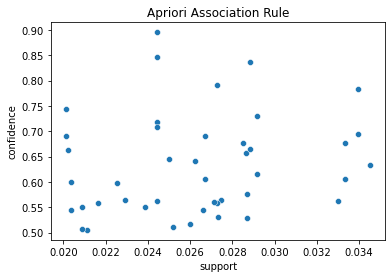

In [121]:
#Based on the frequent itemsets, we will add the condition of minimum confidence equals to 0.5.
#http://rasbt.github.io/mlxtend/user_guide/frequent_patterns/association_rules/
association_rules_Apriori = association_rules(frequent_itemsets_Apriori, metric="confidence", min_threshold=0.5)

#Plot the scatter plot
sns.scatterplot(x='support', y='confidence', data=association_rules_Apriori).set(title='Apriori Association Rule')

/Users/oujunhao/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[Text(0.5, 1.0, 'FP-Growth Association Rule')]

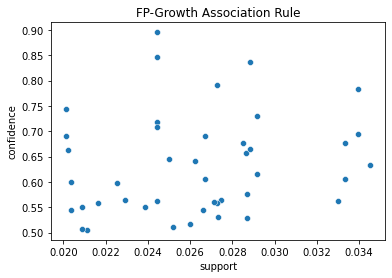

In [122]:
association_rules_FP = association_rules(frequent_itemsets_FP, metric="confidence", min_threshold=0.5)

#Plot the scatter plot
sns.scatterplot(x='support', y='confidence', data=association_rules_FP).set(title='FP-Growth Association Rule')

4. Discuss the rules when the support is larger than 0.028 (2.8%) and confidence is larger than 0.5 (50%).

In [123]:
#Let's set the support to 0.03 and confidence to 0.7
frequent_itemsets_Apriori = apriori(df_new, min_support = 0.03, use_colnames = True)
association_rules_Apriori = association_rules(frequent_itemsets_Apriori, metric="confidence", min_threshold=0.7)
association_rules_Apriori

/Users/oujunhao/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(22697),(22699),0.043379,0.048881,0.033957,0.782799,16.014464,0.031837,4.378979


In [124]:
frequent_itemsets_FP = fpgrowth(df_new,min_support=0.03, use_colnames=True)
association_rules_FP = association_rules(frequent_itemsets_FP, metric="confidence", min_threshold=0.7)
association_rules_FP

/Users/oujunhao/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(22697),(22699),0.043379,0.048881,0.033957,0.782799,16.014464,0.031837,4.378979
